<a href="https://colab.research.google.com/github/jplineb/FASTWASON/blob/master/Watson_FAST_Model_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import plotly.plotly as py
import plotly.graph_objs as go


In [0]:
calib_frac = 0.33

## Load and prepare the data

In [314]:
df = pd.read_csv("FASTDataFrameNice.csv")
df.head()

,Unnamed: 0,img_name,actual_qual,Quality 1,Quality 2,Quality 3,Quality 4,Quality 5,predicted_qual
0,0,video33327.mp4__frame176.png,1,0.907,0.001,0.000,0.000,0.000,1.001101
1,1,video33642.mp4__frame110.png,1,0.418,0.108,0.153,0.663,0.004,2.797177
2,2,video33642.mp4__frame66.png,1,0.891,0.017,0.031,0.035,0.000,1.188912
3,3,video33671.mp4__frame66.png,1,0.031,0.269,0.833,0.004,0.000,2.712401
4,4,video33671.mp4__frame88.png,1,0.010,0.898,0.035,0.001,0.000,2.028602


In [315]:
# pull off target and variable columns
y = df.actual_qual.values
X = df.iloc[:, 3:8].values
X[:5]

array([[0.907, 0.001, 0.   , 0.   , 0.   ],
       [0.418, 0.108, 0.153, 0.663, 0.004],
       [0.891, 0.017, 0.031, 0.035, 0.   ],
       [0.031, 0.269, 0.833, 0.004, 0.   ],
       [0.01 , 0.898, 0.035, 0.001, 0.   ]])

In [316]:
# get sample weights to balance quality levels
qual_counts = df.groupby("actual_qual")['actual_qual'].agg('count').values
print(qual_counts)
print(sum(qual_counts))
weights =  (234/5)/qual_counts
weights = weights**2
print(weights)
print(qual_counts/ sum(qual_counts) * weights)

def get_weight(qual):
  wt = weights[qual-1]
  return wt

get_weight(3)

y_weights = df.actual_qual.apply(get_weight)
print(y_weights)

[35 69 62 43 25]
234
[1.78795102 0.46003781 0.56978148 1.18455381 3.504384  ]
[0.26742857 0.13565217 0.15096774 0.21767442 0.3744    ]
0      1.787951
1      1.787951
2      1.787951
3      1.787951
4      1.787951
5      1.787951
6      1.787951
7      1.787951
8      1.787951
9      1.787951
10     1.787951
11     1.787951
12     1.787951
13     1.787951
14     1.787951
15     1.787951
16     1.787951
17     1.787951
18     1.787951
19     1.787951
20     1.787951
21     1.787951
22     1.787951
23     1.787951
24     1.787951
25     1.787951
26     1.787951
27     1.787951
28     1.787951
29     1.787951
         ...   
204    1.184554
205    1.184554
206    1.184554
207    1.184554
208    1.184554
209    3.504384
210    3.504384
211    3.504384
212    3.504384
213    3.504384
214    3.504384
215    3.504384
216    3.504384
217    3.504384
218    3.504384
219    3.504384
220    3.504384
221    3.504384
222    3.504384
223    3.504384
224    3.504384
225    3.504384
226    3.504384
2

In [317]:
df['Weights'] = y_weights
df.head()

,Unnamed: 0,img_name,actual_qual,Quality 1,Quality 2,Quality 3,Quality 4,Quality 5,predicted_qual,Weights
0,0,video33327.mp4__frame176.png,1,0.907,0.001,0.000,0.000,0.000,1.001101,1.787951
1,1,video33642.mp4__frame110.png,1,0.418,0.108,0.153,0.663,0.004,2.797177,1.787951
2,2,video33642.mp4__frame66.png,1,0.891,0.017,0.031,0.035,0.000,1.188912,1.787951
3,3,video33671.mp4__frame66.png,1,0.031,0.269,0.833,0.004,0.000,2.712401,1.787951
4,4,video33671.mp4__frame88.png,1,0.010,0.898,0.035,0.001,0.000,2.028602,1.787951


In [318]:
# train/test split
# X_train, X_test, y_train, y_test, y_weights_train, _ = train_test_split(X, y, y_weights, test_size=1-calib_frac, stratify=y)
df_train, df_test = train_test_split(df, test_size=1-calib_frac, stratify=df.actual_qual)
print(df_train.shape)
df_test.head()

(77, 10)


,Unnamed: 0,img_name,actual_qual,Quality 1,Quality 2,Quality 3,Quality 4,Quality 5,predicted_qual,Weights
230,230,video35132[1].mp4__frame66.png,5,0.000,0.001,0.033,0.897,0.019,3.983158,3.504384
117,117,video33540.mp4__frame22.png,3,0.008,0.086,0.869,0.083,0.003,2.987607,0.569781
233,233,video35898.mp4__frame44.png,5,0.000,0.001,0.111,0.881,0.019,3.907115,3.504384
143,143,video33941.mp4__frame44.png,3,0.002,0.272,0.409,0.296,0.454,3.647592,0.569781
209,209,video33615.mp4__frame110.png,5,0.000,0.000,0.696,0.561,0.015,3.464623,3.504384


In [319]:
# Split the train and test data set

### Test ###
y_dftest = df_test.actual_qual.values # is array
x_dftest = df_test.iloc[:, 3:8].values # is array


### Train ###
y_dftrain = df_train.actual_qual.values # is array
x_dftrain = df_train.iloc[:, 3:8].values # is array
y_dftrain_weights = df_train.Weights.values # is array
x_dftrain[1:3]


array([[0.906, 0.003, 0.   , 0.   , 0.   ],
       [0.601, 0.252, 0.473, 0.041, 0.002]])

In [320]:
print(x_dftrain.shape)
print(x_dftest.shape)
print(y_dftrain.shape)
print(y_dftest.shape)
print(y_dftrain_weights.shape)

(77, 5)
(157, 5)
(77,)
(157,)
(77,)


## Train the calibration model

In [321]:
estim = LinearRegression(fit_intercept= False)
estim.fit(x_dftrain, y_dftrain, sample_weight=y_dftrain_weights)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [322]:
# evaluate the mode:

# look at fit coefs
print(estim.coef_)
# -> array([1.76293662, 2.13542102, 2.92516357, 3.10297302, 3.49912872])

[1.11958784 1.29530026 3.56708133 4.05151607 3.40425124]


## Get final scores

In [0]:
# evaluate model on training set
y_test_pred = estim.predict(x_dftest)

In [324]:
np.sqrt(mean_squared_error(y_dftest, y_test_pred))

1.0965743668786372

In [325]:
mean_absolute_error(y_dftest, y_test_pred)

0.860655873403782

In [326]:
df_eval = pd.DataFrame(x_dftest)
df_eval['y_test'] = y_dftest
df_eval['y_test_pred'] = y_test_pred
df_eval.head()

,0,1,2,3,4,y_test,y_test_pred
0,0.000,0.001,0.033,0.897,0.019,5,3.817900
1,0.008,0.086,0.869,0.083,0.003,3,3.566635
2,0.000,0.001,0.111,0.881,0.019,5,4.031308
3,0.002,0.272,0.409,0.296,0.454,3,4.558276
4,0.000,0.000,0.696,0.561,0.015,5,4.806653


In [327]:
df_fulltest = df_test.reset_index()
df_fulltest['calibration_predict'] = y_test_pred
df_fulltest.head()

,index,Unnamed: 0,img_name,actual_qual,Quality 1,Quality 2,Quality 3,Quality 4,Quality 5,predicted_qual,Weights,calibration_predict
0,230,230,video35132[1].mp4__frame66.png,5,0.000,0.001,0.033,0.897,0.019,3.983158,3.504384,3.817900
1,117,117,video33540.mp4__frame22.png,3,0.008,0.086,0.869,0.083,0.003,2.987607,0.569781,3.566635
2,233,233,video35898.mp4__frame44.png,5,0.000,0.001,0.111,0.881,0.019,3.907115,3.504384,4.031308
3,143,143,video33941.mp4__frame44.png,3,0.002,0.272,0.409,0.296,0.454,3.647592,0.569781,4.558276
4,209,209,video33615.mp4__frame110.png,5,0.000,0.000,0.696,0.561,0.015,3.464623,3.504384,4.806653


In [328]:
# df_eval.groupby(y_test).apply(lambda x: np.sqrt(mean_squared_error(x.y_test, x.y_test_pred)))
meanerrorforclass = df_eval.groupby(y_dftest).apply(lambda x: mean_absolute_error(x.y_test, x.y_test_pred))

print(meanerrorforclass)

1    0.527741
2    0.938324
3    0.868772
4    0.805106
5    1.175618
dtype: float64


## Merge on img_name

In [329]:
df_quadrants = pd.read_csv("quadrant_confidence.csv") # loads in qudrants with img names csv
df_quadrants.head()


,Unnamed: 0,Unnamed: 0.1,actual_class,predicted_class,img_name,Quadrant
0,0,0,Quality 1,"[{""class"": ""Quality 1"", ""score"": 0.907}, {""cla...",video33327.mp4__frame176.png,unknown
1,1,0,Quality 1,"[{""class"": ""Quality 1"", ""score"": 0.907}, {""cla...",video33327.mp4__frame176.png,unknown
2,2,1,Quality 1,"[{""class"": ""Quality 1"", ""score"": 0.418}, {""cla...",video33642.mp4__frame110.png,unknown
3,3,1,Quality 1,"[{""class"": ""Quality 1"", ""score"": 0.418}, {""cla...",video33642.mp4__frame110.png,unknown
4,4,2,Quality 1,"[{""class"": ""Quality 1"", ""score"": 0.891}, {""cla...",video33642.mp4__frame66.png,unknown


In [330]:
dfquadcolumns = ["img_name", "Quadrant"]
df_quadrants = df_quadrants.reindex(columns = dfquadcolumns)
df_quadrants.head()

,img_name,Quadrant
0,video33327.mp4__frame176.png,unknown
1,video33327.mp4__frame176.png,unknown
2,video33642.mp4__frame110.png,unknown
3,video33642.mp4__frame110.png,unknown
4,video33642.mp4__frame66.png,unknown


In [331]:
df_final = df_fulltest.merge(df_quadrants, on = "img_name") # creates final data frame 
df_final.head()


,index,Unnamed: 0,img_name,actual_qual,Quality 1,Quality 2,Quality 3,Quality 4,Quality 5,predicted_qual,Weights,calibration_predict,Quadrant
0,230,230,video35132[1].mp4__frame66.png,5,0.000,0.001,0.033,0.897,0.019,3.983158,3.504384,3.817900,subcostal
1,117,117,video33540.mp4__frame22.png,3,0.008,0.086,0.869,0.083,0.003,2.987607,0.569781,3.566635,right_upper_quadrant
2,117,117,video33540.mp4__frame22.png,3,0.008,0.086,0.869,0.083,0.003,2.987607,0.569781,3.566635,right_upper_quadrant
3,233,233,video35898.mp4__frame44.png,5,0.000,0.001,0.111,0.881,0.019,3.907115,3.504384,4.031308,left_upper_quadrant
4,143,143,video33941.mp4__frame44.png,3,0.002,0.272,0.409,0.296,0.454,3.647592,0.569781,4.558276,right_upper_quadrant


In [0]:
dffinalcolumns = ["img_name", "actual_qual", "Quality 1", "Quality 2", "Quality 3", "Quality 4", "Quality 5", "Weights", "predicted_qual", "calibration_predict", "Quadrant" ]
df_final = df_final.reindex(columns = dffinalcolumns)
df_final.head()
df_final.to_csv("Calibrated_Model_Predictions.csv")

In [347]:
dferrorquads = df_final.groupby(['actual_qual', 'Quadrant']).apply(lambda x: mean_absolute_error(x.actual_qual, x.calibration_predict))
dferrorquads = pd.DataFrame(data = dferrorquads)
dferrorquads


0
actual_qual Quadrant                      
1           right_upper_quadrant  0.168517
            subcostal             0.016937
            unknown               0.628947
2           left_upper_quadrant   0.835893
            right_upper_quadrant  0.976148
            subcostal             1.233591
            suprapubic            1.085858
            unknown               0.786644
3           left_upper_quadrant   0.955783
            right_upper_quadrant  0.904806
            suprapubic            0.747386
            unknown               1.218234
4           left_upper_quadrant   0.565148
            right_upper_quadrant  0.523189
            subcostal             0.974427
            suprapubic            0.985855
5           left_upper_quadrant   1.131554
            pneumothorax          3.878387
            right_upper_quadrant  1.126832
            subcostal             0.487731
            suprapubic            1.155488
            unknown               3.878387

In [339]:

dferrorqual = df_final.groupby(["actual_qual"]).apply(lambda x: mean_absolute_error(x.actual_qual, x.calibration_predict))
dferrorqual.head()

actual_qual
1    0.587699
2    0.983165
3    0.915688
4    0.722099
5    1.290814
dtype: float64

## Get outputs

In [0]:
# confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
  

CalQual = df_final["calibration_predict"].values.tolist()
i = 0
for x in CalQual:
  if x<1:
    CalQual[i] = 1
  elif x> 5:
    CalQual[i] = 5
  else:
    CalQual[i] = round(x)
  i = i + 1
  
print(CalQual) 
  
TruQual = df_final['actual_qual'].values.tolist()

a = plot_confusion_matrix(TruQual, CalQual, classes = ['Quality 1', 'Quality 2', 'Quality 3', 'Quality 4', 'Quality 5']) 
  
plt.savefig("confusion_matrix_WOnorm.png")  
  


Normalized confusion matrix
[[0.69230769 0.11538462 0.11538462 0.07692308 0.        ]
 [0.25862069 0.22413793 0.44827586 0.05172414 0.01724138]
 [0.10714286 0.16071429 0.26785714 0.35714286 0.10714286]
 [0.         0.12195122 0.29268293 0.26829268 0.31707317]
 [0.08695652 0.08695652 0.04347826 0.47826087 0.30434783]]


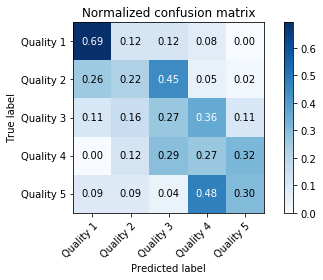

In [353]:
# confusion matrix with normalization
b = plot_confusion_matrix(TruQual, CalQual, normalize = True, classes = ['Quality 1', 'Quality 2', 'Quality 3', 'Quality 4', 'Quality 5'] )


plt.savefig("confusion_matrix_norm.png")

In [0]:
# nice quality-level performance table


In [0]:
# quality-level performance by region

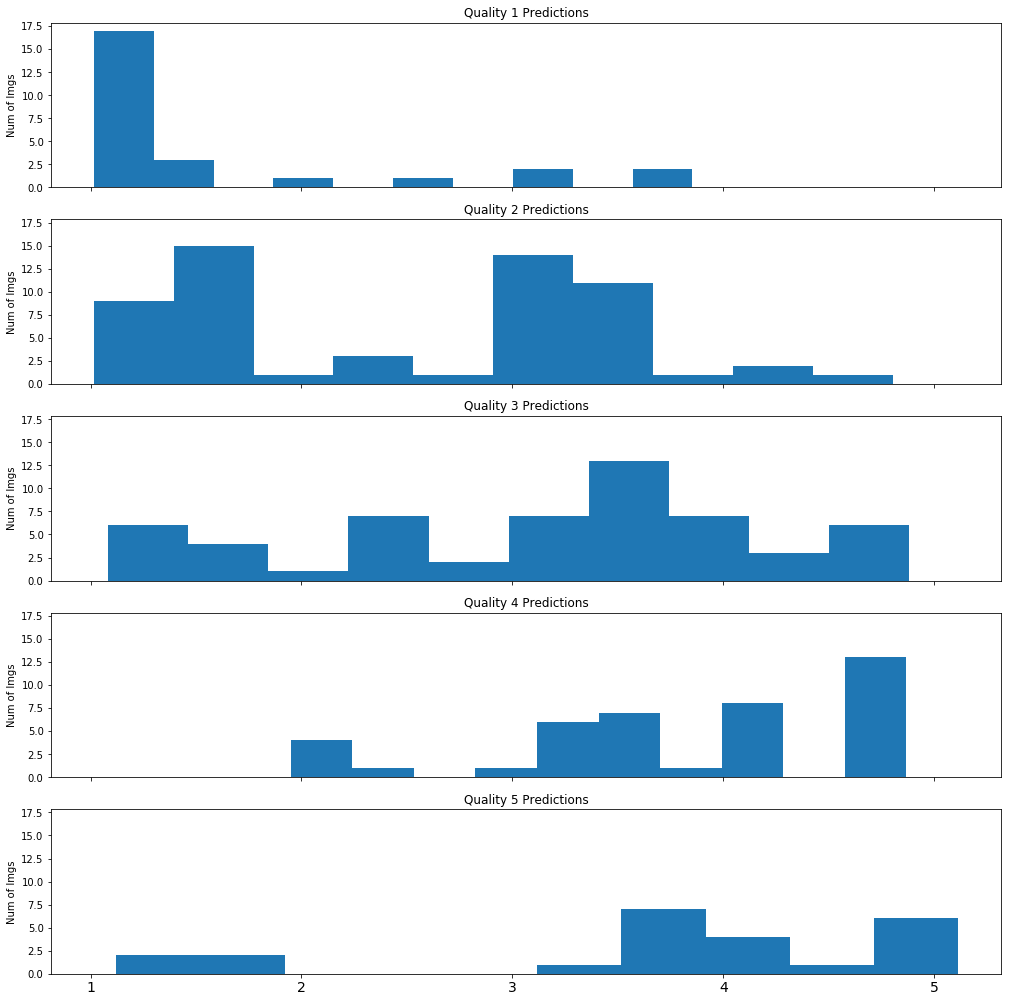

In [354]:
# Distribution of predication sfor each equality level 

fig, axarr = plt.subplots(5, sharex=True, sharey=True, figsize=(14,14))
for i in range(1,6):
 
  dfi = df_final.loc[df_final.actual_qual==i, ]
  ax = axarr[i-1]
  ax.hist(dfi['calibration_predict']);
  plottitle = "Quality " + str(i) + " Predictions"
  ax.set_title(plottitle)
  ax.set_ylabel('Num of Imgs')
  plt.setp(ax.get_xticklabels(), fontsize = 14)
  
  

# plt.xlim([0,1])
# plt.ylim([0,10])
plt.tight_layout(pad=1)
fig.show()
plt.savefig("Distribution_of_predictions_for_each_quality_level.png")


In [337]:
plt.savefig("Distribution_of_predictions_for_each_quality_level.png")


<Figure size 432x288 with 0 Axes>